### EXP: Full launch expert QC rating 

- **Aim:** First full launch of quality control (QC) of brain registration on the Zooniverse platform with expert raters. Raters asked to rate on rate at their pace on zooniverse platform. ( ref: https://www.zooniverse.org/projects/simexp/brain-match ).

- **Exp:** 
    - We choose 100 anatomical brain images (?? OK, ?? Maybe and ?? Fail)   preprocced with NIAK pipelines from ADHD200 and COBRE datsets.
    - We asked raters on the Zooniverse platform to QC images based on the tutorial and the rated sample images.

In [310]:
import os
import pandas as pd
import numpy as np
import json
import itertools
import seaborn as sns
from sklearn import metrics
from matplotlib import gridspec as gs
import matplotlib.pyplot as plt
from functools import reduce

In [311]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set(style="white")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [312]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [313]:
# Read raw table
classifications = pd.read_csv('../data/rating/brain-match-classifications-12-10-2018.csv', 
                              converters={'metadata':CustomParser,
                                          'annotations':CustomParser,
                                          'subject_data':CustomParser},
                              header=0)

In [314]:
# List all workflows 
classifications.workflow_name.unique()

array(['Spot anatomical differences', 'Spot functional differences',
       'anat_internal_rating_pierre', 'anat_internal_rating_yassine',
       'Training Session', 'Basile', 'Benjamin', 'Maxime', 'Angela',
       'Sara', 'Pierre_func_rate_1', 'Pierre_anat_rate1',
       'Yassine_func_rate_1', 'Pierre_func_rate_2', 'Start Project',
       'Start Project 1', 'Expert Project 1', 'Expert Project 2',
       'Start Project 2'], dtype=object)

In [315]:
# Filter out only specific workflows and users
ratings = classifications.loc[classifications['workflow_name'].isin(['Expert Project 1'])]
# Get 3 experts from previous workflow
rating_ = classifications.loc[classifications['workflow_name'].isin(['Start Project 1'])]
rating_ = rating_[rating_.user_name.isin([ 'colezweber','ppf','jenichen'])]
ratings = ratings.append(rating_)
ratings.count()

classification_id    961
user_name            961
user_id              961
user_ip              961
workflow_id          961
workflow_name        961
workflow_version     961
created_at           961
gold_standard          0
expert                 0
metadata             961
annotations          961
subject_data         961
subject_ids          961
dtype: int64

In [316]:
# extract tagging count
ratings.loc[:,"n_tagging"] = [ len(q[0]['value']) for q in ratings.annotations]
# extract rating count
ratings.loc[:,"rating"] = [ q[1]['value'] for q in ratings.annotations]
# extract subjects id
ratings.loc[:,"ID"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['subject_ID'] for ind,row in ratings.iterrows()]
# extract files name
ratings.loc[:,"imgnm"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['image1'] for ind,row in ratings.iterrows()]

In [317]:
# Remove 1 non-experts('alinanaseer' because she rated twice the imges) raters and keep the other one 'ashherr17'
ratings = ratings[~ratings.user_name.isin(['alinanaseer'])]

In [318]:
# How many rating per user
user_count = ratings.user_name.value_counts()
user_count

ppf           213
colezweber    149
jenichen      127
ashherr17     118
angelatam     101
abadhwar      100
Name: user_name, dtype: int64

In [319]:
#select only users that have rated a certain ammount of images 
list_user = user_count.index
list_user = list_user[user_count.values>=10]
user_count[list_user]

ppf           213
colezweber    149
jenichen      127
ashherr17     118
angelatam     101
abadhwar      100
Name: user_name, dtype: int64

In [320]:
# remove users with less rating then the selected threshold
ratings = ratings[ratings.user_name.isin(list_user)]
ratings.count()

classification_id    808
user_name            808
user_id              808
user_ip              808
workflow_id          808
workflow_name        808
workflow_version     808
created_at           808
gold_standard          0
expert                 0
metadata             808
annotations          808
subject_data         808
subject_ids          808
n_tagging            808
rating               808
ID                   808
imgnm                808
dtype: int64

In [321]:
# drop duplicated rating
inc = 0
sum_dup = 0
for ind,user in enumerate(ratings.user_name.unique()):
    user_select_df = ratings[ratings.user_name.isin([user])]
    mask=~user_select_df.ID.duplicated()
    dup = len([m for m in mask if m == False])
    sum_dup = sum_dup+ dup
    if dup > 0 :
        print('{} have {} duplicated ratings'.format(user,dup))
    if ind == 0 and inc == 0:
        classi_unique= user_select_df[mask]
        inc+=1
    else:
        classi_unique = classi_unique.append(user_select_df[~user_select_df.ID.duplicated()])
        inc+=1
print('Total number of duplicated ratings  = {}'.format(sum_dup))

angelatam have 1 duplicated ratings
jenichen have 27 duplicated ratings
ashherr17 have 18 duplicated ratings
ppf have 113 duplicated ratings
colezweber have 49 duplicated ratings
Total number of duplicated ratings  = 208


In [322]:
# Get the final rating numbers per subject
user_count = classi_unique.user_name.value_counts()
user_count

angelatam     100
colezweber    100
ppf           100
ashherr17     100
jenichen      100
abadhwar      100
Name: user_name, dtype: int64

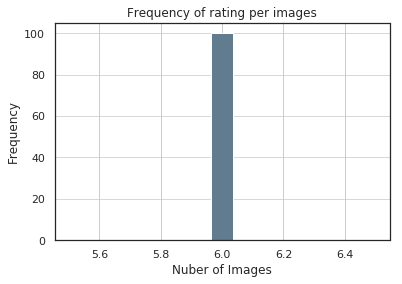

In [323]:
# plot rating per image distribution
image_count = classi_unique.subject_ids.value_counts()
image_count.plot.hist(grid=True,rwidth=0.9, bins=13,color='#607c8e')
plt.title('Frequency of rating per images')
plt.xlabel('Nuber of Images')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [324]:
#Create Users rating dataframe
list_user = user_count.index
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)
df_ratings.head()

,ID,angelatam,colezweber,ppf,ashherr17,jenichen,abadhwar
0,X8628223,Maybe,OK,OK,OK,OK,OK
1,X0010088,OK,OK,OK,Maybe,Maybe,Maybe
2,X0021015,Maybe,OK,OK,OK,Fail,Maybe
3,X3011311,OK,OK,OK,OK,OK,OK
4,X3433846,Maybe,OK,OK,OK,Maybe,Maybe


In [325]:
# remove duplicates
df_ratings = df_ratings[~df_ratings.ID.duplicated()]

### Explore the concensus of rating between images

In [326]:
# Get ratings from images rated more tan N different rates 
n = 4 # Minimun number of ratings per image
stuff = np.array([[row.ID,
                   np.sum(row[1:].values=='Fail'),
                   np.sum(row[1:].values=='Maybe'),
                   np.sum(row[1:].values=='OK')]  
                  for ind, row in df_ratings.iterrows() if np.sum([np.sum(row[1:-1].values=='Fail'),
                                                                 np.sum(row[1:-1].values=='Maybe'),
                                                                 np.sum(row[1:-1].values=='OK')]) >= n])
df_score = pd.DataFrame(data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])
df_score.head()

,ID,Fail,Maybe,OK
0,X8628223,0,1,5
1,X0010088,0,3,3
2,X0021015,1,2,3
3,X3011311,0,0,6
4,X3433846,0,3,3


In [327]:
# Normalise table's row
df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
df_norm = pd.DataFrame( index=df_score.index,columns=['ID','Fail', 'Maybe', 'OK'])
for status in ['Fail','Maybe','OK']:
    for image in df_score.index:
        df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
        df_norm['ID'][image] = df_score['ID'][image]
# get max value
max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
df_norm.loc[:,'max_value_NoExp'] = max_value
# get concensus rating
s = ['Fail', 'Maybe', 'OK']
#max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
max_rate = [s[row[1:].values.argmax()] for rid, row in df_norm.iterrows()]
df_norm.loc[:,'concensus_NoExp'] = max_rate
df_norm.head()

,ID,Fail,Maybe,OK,max_value_NoExp,concensus_NoExp
0,X8628223,0,0.166667,0.833333,0.833333,OK
1,X0010088,0,0.5,0.5,0.500000,Maybe
2,X0021015,0.166667,0.333333,0.5,0.500000,OK
3,X3011311,0,0,1,1.000000,OK
4,X3433846,0,0.5,0.5,0.500000,Maybe


Text(0, 0.5, 'Concensus rating')

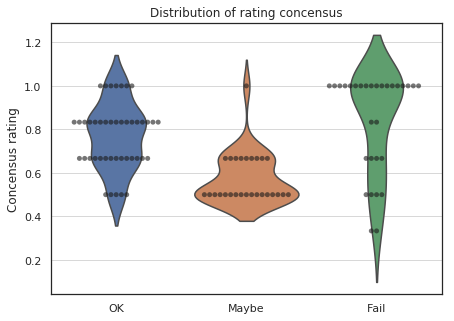

In [328]:
#Setting the figure with matplotlib
plt.figure(figsize=(7,5))
#plt.xticks(rotation=90)
plt.rcParams["axes.labelsize"] = 12
 
#Creating the desired plot
sns.violinplot(x='concensus_NoExp',y='max_value_NoExp',data=df_norm,
              inner=None #removes the inner bars inside the violins 
              )
 
sns.swarmplot(x='concensus_NoExp',y='max_value_NoExp',data=df_norm,
             color='k',#for making the points black
             alpha=0.6) #value of alpha will increase the transparency
 
#Title for the plot
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of rating concensus')
plt.xlabel('')
plt.ylabel('Concensus rating')

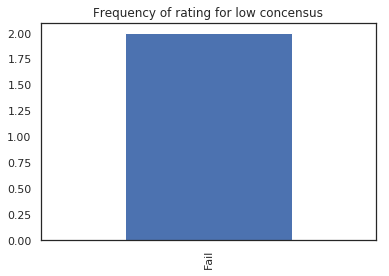

In [329]:
count_ = df_norm.concensus_NoExp[[0 <= row.max_value_NoExp < 0.5   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for low concensus')

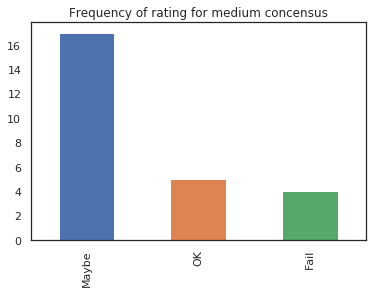

In [330]:
count_ = df_norm.concensus_NoExp[[0.5 <= row.max_value_NoExp < 0.65   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for medium concensus')

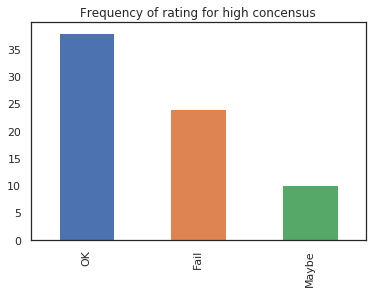

In [331]:
count_ = df_norm.concensus_NoExp[[0.6 < row.max_value_NoExp <= 1   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for high concensus')

In [332]:
# Save a copy
df_ratings.rename(columns={'angelatam':'Atam',
                           'colezweber':'Czwe',
                           'ppf':'Pfer',
                           'jenichen':'Jche',
                           'abadhwar':'Abad',
                           'ashherr17':'Aher'},inplace=True)
df_ratings =df_ratings[['ID','Atam','Abad','Jche','Pfer','Czwe','Aher']]
df_ratings.to_csv('../data/rating/expert_project_1_ratings.csv',index=False)
df_ratings.head()

,ID,Atam,Abad,Jche,Pfer,Czwe,Aher
0,X8628223,Maybe,OK,OK,OK,OK,OK
1,X0010088,OK,Maybe,Maybe,OK,OK,Maybe
2,X0021015,Maybe,Maybe,Fail,OK,OK,OK
3,X3011311,OK,OK,OK,OK,OK,OK
4,X3433846,Maybe,Maybe,Maybe,OK,OK,OK


### Merge Pilot3 and Full launch 1 rating and get Kappa score

In [333]:
# Replace OK with 1 , Maybe with 2 and Fail with 3
df_ratings.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)

df_ratings.head()

,ID,Atam,Abad,Jche,Pfer,Czwe,Aher
0,X8628223,2,1,1,1,1,1
1,X0010088,1,2,2,1,1,2
2,X0021015,2,2,3,1,1,1
3,X3011311,1,1,1,1,1,1
4,X3433846,2,2,2,1,1,1


In [334]:
%%R
suppressPackageStartupMessages(library(dplyr))
#install.packages("irr") 
library(irr)

In [279]:
# Percenteage of agrrement between raters with R package IRR
agree_ = df_ratings.drop(['ID'],axis=1)
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 100 
   Raters = 6 
  %-agree = 26 



In [335]:
# FDR correction
from statsmodels.sandbox.stats import multicomp as smi

def fdr_transf(mat,log10 = False):
    '''compute fdr of a given matrix'''
    
    row = mat.shape[0]
    col = mat.shape[1]
    flatt = mat.flatten()
    fdr_2d = smi.multipletests(flatt, alpha=0.05, method='fdr_bh')[1]
    if log10 == True:
        fdr_2d = [-np.log10(ii) if ii != 0 else 50 for ii in fdr_2d  ]
    fdr_3d = np.reshape(fdr_2d,(row,col))
    return fdr_3d

In [336]:
# Kappa calculation
def kappa_score(k_df,log10 = False):
    '''compute Kappa between diferent raters organized in dataframe'''
    k_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    p_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    %Rpush k_df
    for user1_id, user1 in enumerate(k_df.columns):
        for user2_id, user2 in enumerate(k_df.columns):
            weight = np.unique(kappa_df[[user1,user2]])
            %Rpush user1_id user1 user2_id user2 weight
            kappaR =  %R kappa2(k_df[,c(user1,user2)],weight)
            
            # store the kappa
            k_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][4]
            p_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][-1]
            
    # FDR Correction       
    p_store = fdr_transf(p_store,log10)
    return k_store, p_store

In [337]:
# Get Kappa score out of all different combination of ratings
kappa_df  = df_ratings.drop(['ID'],axis=1)
kappa_store, Pval_store = kappa_score(kappa_df)
mean_kap = np.mean(kappa_store[np.triu_indices(len(kappa_store),k=1)])
std_kap = np.std(kappa_store[np.triu_indices(len(kappa_store),k=1)])
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Mean Kappa : 0.50 , std : 0.07

 Fleiss' Kappa for m Raters

 Subjects = 100 
   Raters = 6 
    Kappa = 0.382 

        z = 20.7 
  p-value = 0 



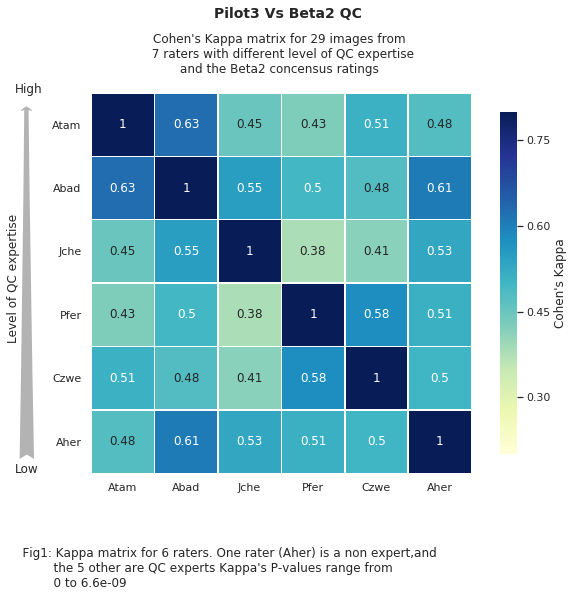

In [347]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (10,7))
f.subplots_adjust(hspace= .8)

f.suptitle('Pilot3 Vs Beta2 QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0.2,vmax=0.8,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix for {} images from \n  7 raters with different level of QC expertise \n and the Beta2 concensus ratings  ".format(len(merge_ratings)),
               pad=20,fontsize=12)
axes.annotate('Low', xy=(-0.17, 0.97),xytext=(-0.2, -0), xycoords='axes fraction',
              arrowprops=dict(arrowstyle="fancy,tail_width=1.2,head_width=01",
                            fc="0.7", ec="none",
                            linewidth =2))

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for 6 raters. One rater (Aher) is a non expert,and 
            the 5 other are QC experts Kappa's P-values range from
            {:.2g} to {:.2g} '''.format(Pval_store.min(), Pval_store.max())
f.text(0.1,-0.1,txt,fontsize=12)
f.text(0.11,0.88,'High',fontsize=12)
f.text(0.10,0.62,'Level of QC expertise',fontsize=12,rotation=90)
# Save figure
f.savefig('../reports/figures/Full-Launch-non-supervised-experts_qc.svg')

In [339]:
from IPython.display import Image
Image(url= "https://i.stack.imgur.com/kYNd6.png" ,width=600, height=600)

### Report tagging from Full lanch 1 raters

In [340]:
# output markings from classifications
clist=[]
for index, c in classi_unique.iterrows():
    if c['n_tagging'] > 0:
        for q in c.annotations[0]['value']:
            clist.append({'ID':c.ID, 'workflow_name':c.workflow_name,'user_name':c.user_name, 'rating':c.rating,'imgnm':c.imgnm, 
                          'x':q['x'], 'y':np.round(q['y']).astype(int), 'r':'1.5','n_tagging':c.n_tagging ,'frame':q['frame']})
    else:
        clist.append({'ID':c.ID, 'workflow_name':c.workflow_name, 'user_name':c.user_name,'rating':c.rating,'imgnm':c.imgnm, 
                          'x':float('nan'), 'y':float('nan'), 'r':float('nan'),'n_tagging':c.n_tagging ,'frame':'1'})

col_order=['ID','workflow_name','user_name','rating','x','y','r','n_tagging','imgnm','frame']
out_tag = pd.DataFrame(clist)[col_order]
out_tag.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
0,X8628223,Expert Project 1,angelatam,Maybe,471.46875,599.0,1.5,1,X_8628223_anat.png,0
1,X0010088,Expert Project 1,angelatam,OK,NaN,NaN,NaN,0,X_0010088_anat.png,1
2,X0021015,Expert Project 1,angelatam,Maybe,47.46875,662.0,1.5,1,X_0021015_anat.png,0
3,X3011311,Expert Project 1,angelatam,OK,NaN,NaN,NaN,0,X_3011311_anat.png,1
4,X3433846,Expert Project 1,angelatam,Maybe,44.46875,659.0,1.5,2,X_3433846_anat.png,0


In [341]:
# Extract unique IDs for each image
ids_imgnm = np.reshape([out_tag.ID.unique(),out_tag.imgnm.unique()],(2,np.shape(out_tag.ID.unique())[0]))
df_ids_imgnm = pd.DataFrame(np.sort(ids_imgnm.T, axis=0),columns=['ID', 'imgnm'])
df_ids_imgnm.head()

,ID,imgnm
0,HC0040038,HC0040038_anat.png
1,HC0040043,HC0040043_anat.png
2,HC0040045,HC0040045_anat.png
3,HC0040048,HC0040048_anat.png
4,HC0040050,HC0040050_anat.png


In [342]:
# Create custom color map
from matplotlib.colors import LinearSegmentedColormap , ListedColormap
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)


coll,a=_cmap_from_image_path('../data/Misc/custom_ColBar.png')
#invert color map
coll_r = ListedColormap(coll[::-1])

In [343]:
# set color different for each rater
list_tagger = out_tag.user_name.unique()
colors_tagger = sns.color_palette("Set2", len(list_tagger))

### Plot heat map for all tagging

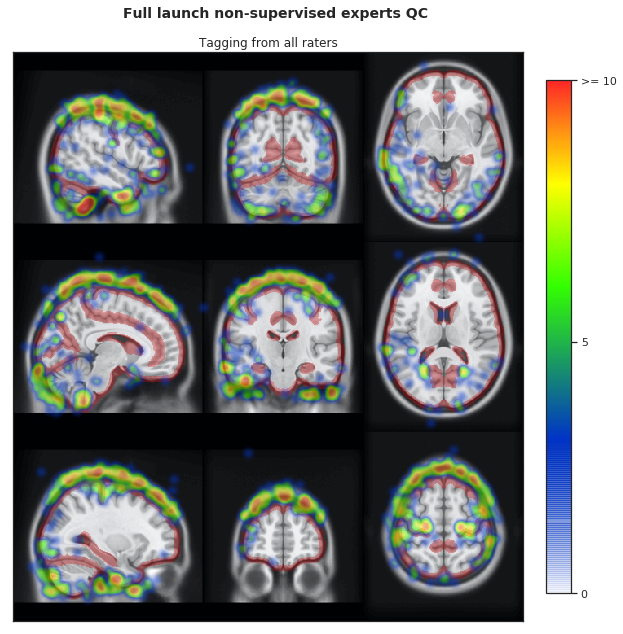

In [346]:
from heatmappy import Heatmapper
from PIL import Image

patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out_tag[out_tag['ID'] == row.ID]
    patches.append([(row.x,row.y) for ind,row in out_tmp.iterrows()])

patches = [x for x in sum(patches,[]) if str(x[0]) != 'nan']

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Full launch non-supervised experts QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v3.png')
axes.set_title('Tagging from all raters')

heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=20,
                        point_strength = 0.3,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patches, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '5', '>= 10'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Full_launch1_non-supervised-experts-heatmap_tags.svg')